In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import umap
import scvelo as scv
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
%load_ext autoreload
%autoreload 2
# set scvelo figures
scv.set_figure_params()

Using device cpu


# 05d01 scVelo on Single Cell Datasets
> Get scVelo's finest embeddings for its hallmark datasets, as baselines

This is a workflow to embed scVelo's datasets using its own state-of-the-art tools -- so that we can compare them to FRED's embeddings.

For each of the datasets, we'll obtain: 
1. scVelo's UMAP visualizations with projected arrows
2. scVelo's latent time computation on the dataset
Both of these will be saved in np txt format for future use.

In [ ]:
notebook = "05d03 scvelo embeddings of sc"
dataset_name = "pancreas"

In [ ]:
# Parameters
notebook = "05d03 scvelo embeddings of sc.ipynb"
dataset_name = "dentategyrus"
run_num = 3
output_label = "run9_dataset_name-dentategyrus_run_num-3"


# Set Up
Adapted from scVelo's tutorials

In [ ]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [ ]:
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
# choose correct dataset
if dataset_name == "bone marrow":
    adata = scv.datasets.bonemarrow()
elif dataset_name == "dentategyrus":
    adata = scv.datasets.dentategyrus()
elif dataset_name == "pancreas":
    adata = scv.datasets.pancreas()
elif dataset_name == "dentategyrus_lamanno":
    adata = scv.datasets.dentategyrus_lamanno()
else:
    print(f"Dataset {dataset_name} does not exist")
    raise NotImplementedError

In [ ]:
from FRED.datasets import rnavelo_preprocess, rnavelo, rnavelo_pcs, rnavelo_add_labels
# preprocess
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 10340 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


Extracted 2000 highly variable genes.
Logarithmized X.


computing neighbors


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
# dynamical recovery
scv.tl.recover_dynamics(adata, n_jobs=1)

scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

scv.tl.latent_time(adata)

recovering dynamics (using 1/28 cores)


  0%|          | 0/975 [00:00<?, ?gene/s]

    finished (0:06:27) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities


    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/28 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states


    identified 5 regions of root cells and 4 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior


    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [ ]:
# get umap embedding of data
scv.tl.umap(adata)

computing velocity embedding


    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


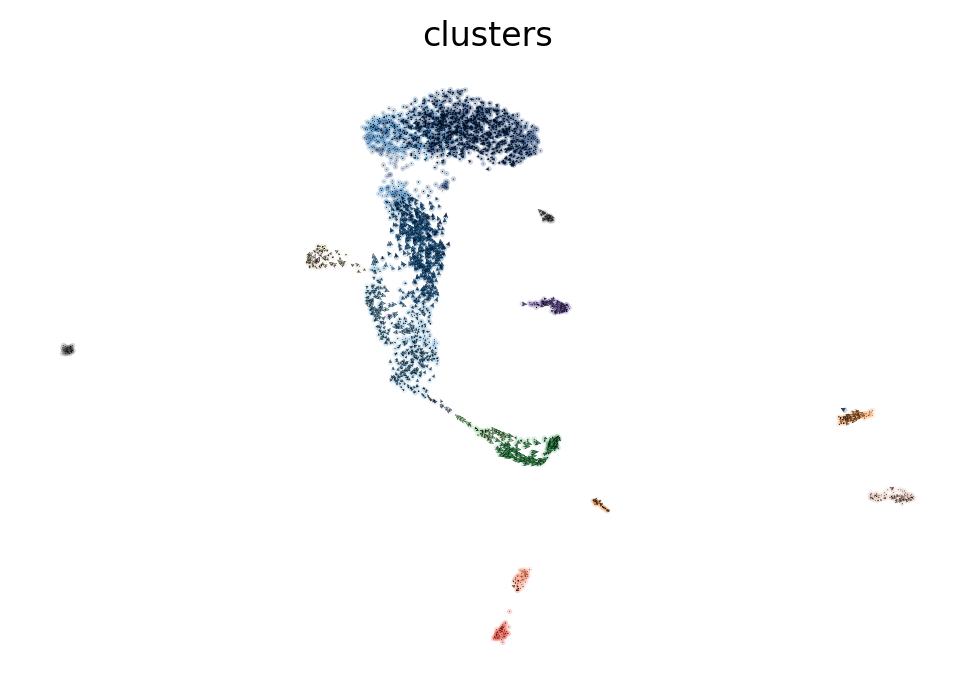

In [ ]:
scv.pl.velocity_embedding(adata, basis='umap')

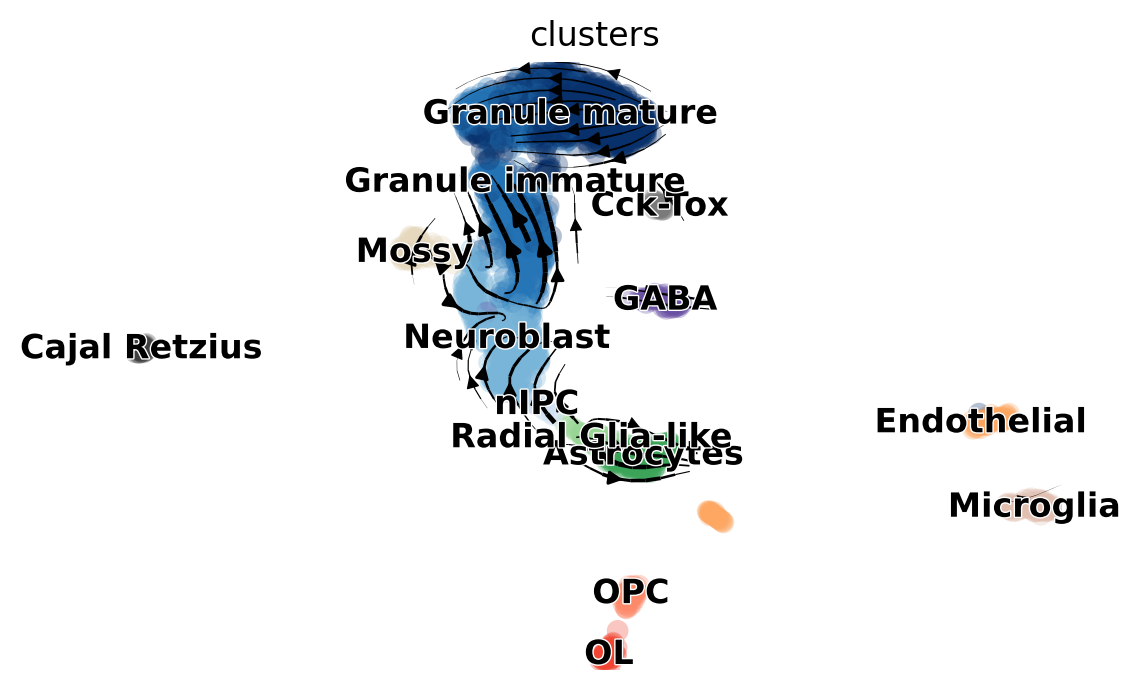

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

In [ ]:
latent_time = adata.obs['latent_time'].to_numpy()

In [ ]:
scv.tl.velocity_embedding(adata, basis='pca', direct_pca_projection=False)

computing velocity embedding


    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


In [ ]:
labels = rnavelo_add_labels(adata)
X = torch.tensor(adata.obsm["X_pca"].copy())
flows = torch.tensor(adata.obsm["velocity_pca"].copy())

# Save embedding for future use

In [ ]:
adata

AnnData object with n_obs × n_vars = 2930 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'umap'
    obsm: 'X_umap', 'X_pca', 'velocity_umap', 'velocity_pca'
    varm: 'PCs', 'loss'
    layers: 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [ ]:
embedded_points = adata.obsm['X_umap']

In [ ]:
embedded_velocities = adata.obsm['velocity_umap']

# Metric Evaluation

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
spread_name = notebook + "_dataset_" + dataset_name
unid

'SJs8Dttk6MGkYVgrTnNz'

In [ ]:
embedded_velocities.shape

(2930, 2)

In [ ]:
from FRED.metrics import comprehensive_flow_metrics
silhouette_score, silhouete_score_with_flow, knn_score, neighbor_score, monotone_score = comprehensive_flow_metrics(
    X = X,
    flows = flows,
    labels = labels,
    embedded_points = embedded_points,
    embedded_velocities = embedded_velocities,
    time_labels = latent_time,
    spreadsheet_name=spread_name,
    unid = unid,
)

Set sigma =  3.5971684


  0%|          | 0/1000 [00:00<?, ?it/s]

## SCORES ## 
 silhouette score w/o flows: 0.30051952600479126.
 silhouette score w/ flows:  0.29988034187495793 
 kNN Classifier 0.8831437435367114 
 Flow Neighbor Score 22053.35100441044 
 Monotone Increasing Score -130.69856698926853


In [ ]:
import csv
with open(f"results/{spread_name}.csv", 'a') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(
            [unid,
            silhouette_score,
            silhouete_score_with_flow,
            knn_score,
            neighbor_score, 
            monotone_score,
            ])